#### 1.Install necessary libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Model
from catboost import CatBoostRegressor, Pool

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


#### 2. Load and Explore Data

In [2]:
# Load the dataset
df = pd.read_csv('../data/car_price.csv')

# Remove the first column (ID column - unnamed index)
df = df.drop(df.columns[0], axis=1)

#### 3. Data Preprocessing

In [3]:
# Create a copy for preprocessing
df_processed = df.copy()

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Price')  # Remove target variable


In [4]:
# Handle missing values
print("=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

# Check for missing values
missing_before = df_processed.isnull().sum().sum()
print(f"\n❌ Total missing values before: {missing_before}")

# Fill numerical missing values with median
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"   • {col}: Filled with median = {median_val:.2f}")

# Fill categorical missing values with mode
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"   • {col}: Filled with mode = {mode_val}")

missing_after = df_processed.isnull().sum().sum()
print(f"\n✅ Total missing values after: {missing_after}")

HANDLING MISSING VALUES

❌ Total missing values before: 0

✅ Total missing values after: 0


In [5]:
# Feature Engineering
print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Convert Date to datetime for Car_Age calculation
df_processed['Date'] = pd.to_datetime(df_processed['Date'])

# Calculate car age (from Year of Manufacture to listing date)
# Using the listing year from Date column
df_processed['Car_Age'] = df_processed['Date'].dt.year - df_processed['YOM']

# Calculate average mileage per year
df_processed['Mileage_Per_Year'] = df_processed['Millage(KM)'] / (df_processed['Car_Age'] + 1)  # +1 to avoid division by zero

# Drop the Date column - we don't use date-based features for prediction
# (Listing_Year, Listing_Month, Listing_Day are not included as features)
df_processed = df_processed.drop('Date', axis=1)

# Create price bins for stratified splitting (based on price ranges)
df_processed['Price_Bin'] = pd.qcut(df_processed['Price'], q=5, labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])

print("✅ Created features: Car_Age, Mileage_Per_Year")
print("ℹ️ Date-based features (Listing_Year, Month, Day) excluded from model")

df_processed.head()

FEATURE ENGINEERING
✅ Created features: Car_Age, Mileage_Per_Year
ℹ️ Date-based features (Listing_Year, Month, Day) excluded from model


,Brand,Model,YOM,Engine (cc),Gear,Fuel Type,Millage(KM),Town,Leasing,Condition,AIR CONDITION,POWER STEERING,POWER MIRROR,POWER WINDOW,Price,Car_Age,Mileage_Per_Year,Price_Bin
0,AUDI,A1,2016,990.0,Automatic,Petrol,99000.0,Gampaha,No Leasing,USED,Available,Available,Available,Available,100.0,9,9900.000000,Very_High
1,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Colombo,No Leasing,USED,Available,Available,Available,Available,97.0,8,9777.777778,Very_High
2,AUDI,A1,2018,1000.0,Automatic,Petrol,77000.0,Dehiwala-Mount-Lavinia,No Leasing,USED,Available,Available,Available,Available,98.5,7,9625.000000,Very_High
3,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Negombo,No Leasing,USED,Available,Available,Available,Available,107.0,7,11000.000000,Very_High
4,AUDI,A1,2017,1000.0,Automatic,Petrol,88000.0,Colombo,No Leasing,USED,Available,Available,Available,Available,99.5,7,11000.000000,Very_High


#### 4. Data splitting

In [6]:
# Prepare features and target
print("=" * 60)
print("STRATIFIED DATA SPLITTING")
print("=" * 60)

# Create stratification key combining Brand and Price_Bin
# This ensures both brand diversity and price range diversity in train/test sets
df_processed['Stratify_Key'] = df_processed['Brand'].astype(str) + '_' + df_processed['Price_Bin'].astype(str)

# Handle rare combinations by grouping them
stratify_counts = df_processed['Stratify_Key'].value_counts()
rare_combinations = stratify_counts[stratify_counts < 2].index
df_processed.loc[df_processed['Stratify_Key'].isin(rare_combinations), 'Stratify_Key'] = 'Other'

# Separate features and target
X = df_processed.drop(['Price', 'Price_Bin', 'Stratify_Key'], axis=1)
y = df_processed['Price']
stratify_key = df_processed['Stratify_Key']

# Identify categorical features for CatBoost (handles both 'object' and 'string' dtypes)
cat_features = [col for col in X.columns if X[col].dtype in ['object', 'string', 'str'] 
                or str(X[col].dtype) == 'str']

print(f"\n📊 Features Shape: {X.shape}")
print(f"📊 Target Shape: {y.shape}")
print(f"\n🏷️ Categorical Features for CatBoost: {cat_features}")

STRATIFIED DATA SPLITTING

📊 Features Shape: (9788, 16)
📊 Target Shape: (9788,)

🏷️ Categorical Features for CatBoost: ['Brand', 'Model', 'Gear', 'Fuel Type', 'Town', 'Leasing', 'Condition', 'AIR CONDITION', 'POWER STEERING', 'POWER MIRROR', 'POWER WINDOW']

📊 Features Shape: (9788, 16)
📊 Target Shape: (9788,)

🏷️ Categorical Features for CatBoost: ['Brand', 'Model', 'Gear', 'Fuel Type', 'Town', 'Leasing', 'Condition', 'AIR CONDITION', 'POWER STEERING', 'POWER MIRROR', 'POWER WINDOW']


In [7]:
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_key
)

print("\n✅ Stratified Split Completed!")
print(f"\n📊 Training Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Test Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification - compare brand distributions
print("\n📈 Brand Distribution Comparison:")
train_brand_dist = X_train['Brand'].value_counts(normalize=True).head(5)
test_brand_dist = X_test['Brand'].value_counts(normalize=True).head(5)

comparison_df = pd.DataFrame({
    'Train %': train_brand_dist * 100,
    'Test %': test_brand_dist * 100
}).round(2)
print(comparison_df)

# Verify price distribution similarity
print("\n📈 Price Distribution Comparison:")
print(f"   Train - Mean: {y_train.mean():.2f}, Median: {y_train.median():.2f}, Std: {y_train.std():.2f}")
print(f"   Test  - Mean: {y_test.mean():.2f}, Median: {y_test.median():.2f}, Std: {y_test.std():.2f}")


✅ Stratified Split Completed!

📊 Training Set: 7830 samples (80.0%)
📊 Test Set: 1958 samples (20.0%)

📈 Brand Distribution Comparison:
            Train %  Test %
Brand                      
TOYOTA        31.56   31.56
SUZUKI        25.25   25.33
NISSAN        12.73   12.82
HONDA          6.96    6.95
MITSUBISHI     2.90    2.91

📈 Price Distribution Comparison:
   Train - Mean: 53.37, Median: 43.00, Std: 43.50
   Test  - Mean: 53.84, Median: 43.17, Std: 44.13


#### 5. Model Training


In [8]:
# Get categorical features from X_train (check for both 'object' and 'string' dtypes)
cat_features = [col for col in X_train.columns if X_train[col].dtype in ['object', 'string', 'str'] 
                or str(X_train[col].dtype) == 'str']
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]

print(f"📋 Categorical Features ({len(cat_features)}): {cat_features}")
print(f"📋 Categorical Feature Indices: {cat_feature_indices}")

# Create CatBoost Pools (optimized data format for CatBoost)
train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=X_test, 
    label=y_test, 
    cat_features=cat_feature_indices
)

print("\n✅ CatBoost Pools created successfully!")
print(f"\n📊 Training Pool: {train_pool.num_row()} samples, {train_pool.num_col()} features")
print(f"📊 Test Pool: {test_pool.num_row()} samples, {test_pool.num_col()} features")

📋 Categorical Features (11): ['Brand', 'Model', 'Gear', 'Fuel Type', 'Town', 'Leasing', 'Condition', 'AIR CONDITION', 'POWER STEERING', 'POWER MIRROR', 'POWER WINDOW']
📋 Categorical Feature Indices: [0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13]



✅ CatBoost Pools created successfully!

📊 Training Pool: 7830 samples, 16 features
📊 Test Pool: 1958 samples, 16 features


In [9]:
# Initialize and train CatBoost model
print("=" * 60)
print("TRAINING CATBOOST MODEL")
print("=" * 60)

# Define the model with optimized hyperparameters
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    min_data_in_leaf=5,
    random_strength=1,
    bagging_temperature=0.5,
    border_count=128,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100,
    use_best_model=True
)

# Train the model
print("\n🚀 Starting model training...\n")
model.fit(
    train_pool,
    eval_set=test_pool,
    plot=False
)

print("\n✅ Model training completed!")
print(f"📊 Best iteration: {model.get_best_iteration()}")

TRAINING CATBOOST MODEL

🚀 Starting model training...

0:	learn: 41.9253966	test: 42.5925801	best: 42.5925801 (0)	total: 224ms	remaining: 3m 43s
0:	learn: 41.9253966	test: 42.5925801	best: 42.5925801 (0)	total: 224ms	remaining: 3m 43s
100:	learn: 14.3056609	test: 15.2040406	best: 15.2040406 (100)	total: 3.92s	remaining: 34.9s
100:	learn: 14.3056609	test: 15.2040406	best: 15.2040406 (100)	total: 3.92s	remaining: 34.9s
200:	learn: 12.2806737	test: 13.9592522	best: 13.9592522 (200)	total: 7.43s	remaining: 29.5s
200:	learn: 12.2806737	test: 13.9592522	best: 13.9592522 (200)	total: 7.43s	remaining: 29.5s
300:	learn: 11.1435615	test: 13.5102567	best: 13.5102567 (300)	total: 11.1s	remaining: 25.7s
300:	learn: 11.1435615	test: 13.5102567	best: 13.5102567 (300)	total: 11.1s	remaining: 25.7s
400:	learn: 10.2615139	test: 13.3249296	best: 13.3062915 (390)	total: 14.8s	remaining: 22.2s
400:	learn: 10.2615139	test: 13.3249296	best: 13.3062915 (390)	total: 14.8s	remaining: 22.2s
500:	learn: 9.4990554

#### 6. Model Evaluation

In [10]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, set_name):
    """Calculate and return regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Set': set_name,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
        'MAPE (%)': mape
    }

# Calculate metrics for both sets
train_metrics = calculate_metrics(y_train, y_train_pred, 'Training')
test_metrics = calculate_metrics(y_test, y_test_pred, 'Test')

# Display results
print("=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print("\n📊 Performance Metrics (Price in 100,000s LKR):\n")

metrics_df = pd.DataFrame([train_metrics, test_metrics])
metrics_df = metrics_df.set_index('Set')
print(metrics_df.round(4).to_string())

# Interpretation
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"""
✅ R² Score: {test_metrics['R² Score']:.4f}
   → Model explains {test_metrics['R² Score']*100:.2f}% of the variance in car prices

✅ RMSE: {test_metrics['RMSE']:.4f} (in 100,000s LKR)
   → Average prediction error: ~{test_metrics['RMSE']*100000:.0f} LKR

✅ MAE: {test_metrics['MAE']:.4f} (in 100,000s LKR)
   → Average absolute error: ~{test_metrics['MAE']*100000:.0f} LKR

✅ MAPE: {test_metrics['MAPE (%)']:.2f}%
   → Average percentage error in predictions
""")

MODEL EVALUATION RESULTS

📊 Performance Metrics (Price in 100,000s LKR):

             RMSE     MAE  R² Score  MAPE (%)
Set                                          
Training   9.6052  4.8630    0.9512   13.2008
Test      12.7174  5.9007    0.9169   15.0118

INTERPRETATION

✅ R² Score: 0.9169
   → Model explains 91.69% of the variance in car prices

✅ RMSE: 12.7174 (in 100,000s LKR)
   → Average prediction error: ~1271738 LKR

✅ MAE: 5.9007 (in 100,000s LKR)
   → Average absolute error: ~590073 LKR

✅ MAPE: 15.01%
   → Average percentage error in predictions



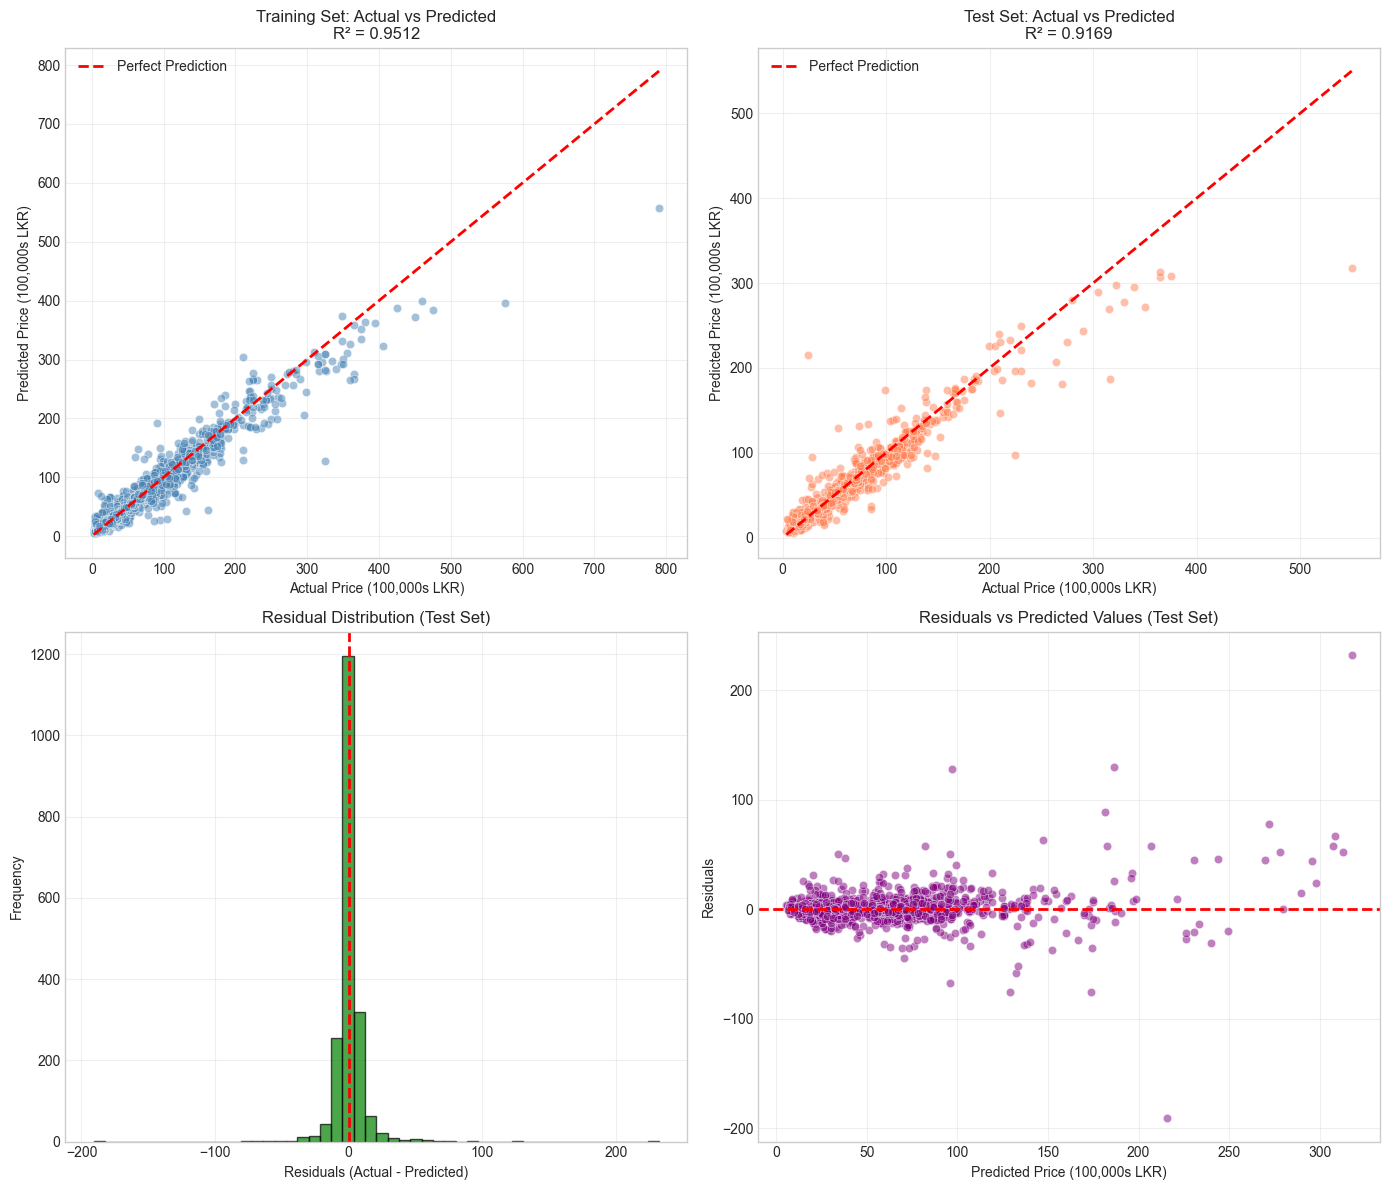

In [11]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.5, color='steelblue', edgecolors='white', linewidth=0.5)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price (100,000s LKR)')
axes[0, 0].set_ylabel('Predicted Price (100,000s LKR)')
axes[0, 0].set_title(f'Training Set: Actual vs Predicted\nR² = {train_metrics["R² Score"]:.4f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test)
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.5, color='coral', edgecolors='white', linewidth=0.5)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Price (100,000s LKR)')
axes[0, 1].set_ylabel('Predicted Price (100,000s LKR)')
axes[0, 1].set_title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R² Score"]:.4f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual Distribution (Test)
residuals = y_test - y_test_pred
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residual Distribution (Test Set)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals vs Predicted
axes[1, 1].scatter(y_test_pred, residuals, alpha=0.5, color='purple', edgecolors='white', linewidth=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Price (100,000s LKR)')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residuals vs Predicted Values (Test Set)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 7. Explainability Analysis (SHAP)

In [12]:
# Get feature importances
feature_importance = model.get_feature_importance()
feature_names = X_train.columns.tolist()

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

import shap

# CatBoost has a built-in fast SHAP implementation via Pool objects
# Calculate SHAP values for the test set
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_pool)

print("✅ SHAP values calculated successfully!")
print(f"📊 SHAP values shape: {shap_values.shape}")
print(f"📊 Expected value (base prediction): {explainer.expected_value:.4f}")

✅ SHAP values calculated successfully!
📊 SHAP values shape: (1958, 16)
📊 Expected value (base prediction): 53.3709


SHAP MEAN ABSOLUTE IMPORTANCE (BAR PLOT)
Shows the average magnitude of each feature's impact



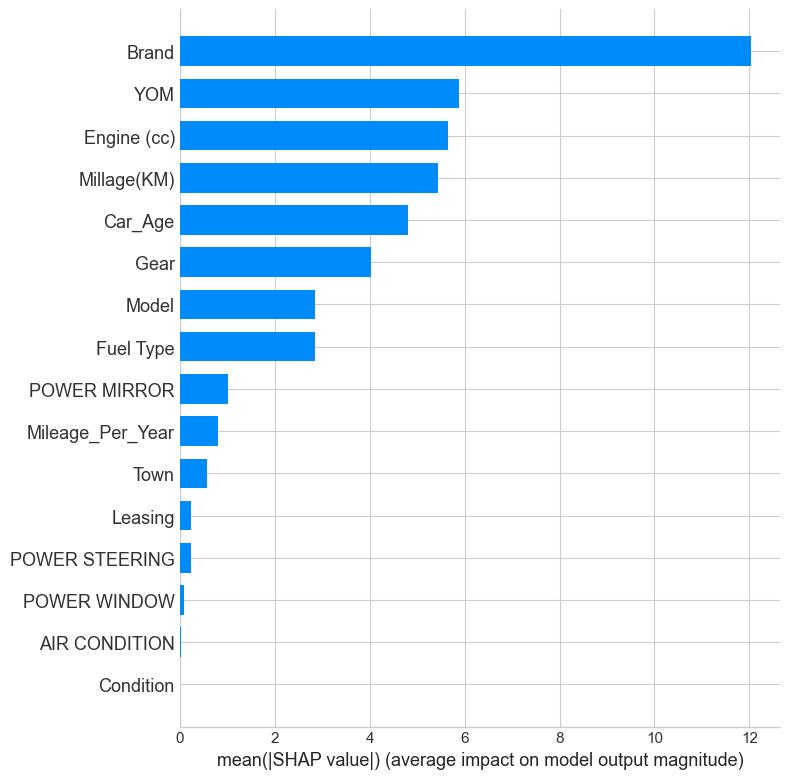

In [13]:
# 1. SHAP Bar Plot (Mean absolute SHAP values - global importance)
print("=" * 60)
print("SHAP MEAN ABSOLUTE IMPORTANCE (BAR PLOT)")
print("=" * 60)
print("Shows the average magnitude of each feature's impact\n")

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=True)

In [14]:
# 2. SHAP Force Plot - Another way to visualize a single prediction
print("=" * 60)
print("SHAP FORCE PLOT (SINGLE PREDICTION)")
print("=" * 60)
print("Red features push the prediction HIGHER, blue features push it LOWER\n")

# Initialize JS visualization (needed for force plots in notebooks)
shap.initjs()

# Force plot for the same sample
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test.iloc[sample_idx],
    feature_names=feature_names,
    matplotlib=True
)
plt.tight_layout()
plt.show()

SHAP FORCE PLOT (SINGLE PREDICTION)
Red features push the prediction HIGHER, blue features push it LOWER



NameError: name 'sample_idx' is not defined

In [ ]:
# 3. SHAP Global Feature Importance Summary Table
print("=" * 60)
print("SHAP FEATURE IMPORTANCE SUMMARY")
print("=" * 60)

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP Value|': mean_abs_shap,
    'Importance %': (mean_abs_shap / mean_abs_shap.sum()) * 100
}).sort_values('Mean |SHAP Value|', ascending=False).reset_index(drop=True)
shap_importance_df.index += 1

print("\n📊 Features ranked by mean absolute SHAP value:\n")
print(shap_importance_df.round(4).to_string())

# Compare CatBoost native importance vs SHAP importance
print("\n\n📈 Key Insight: SHAP values provide a more theoretically grounded")
print("   importance measure than CatBoost's built-in feature importance,")
print("   as they account for feature interactions and have additive properties.")

SHAP FEATURE IMPORTANCE SUMMARY

📊 Features ranked by mean absolute SHAP value:

             Feature  Mean |SHAP Value|  Importance %
1              Brand            12.0414       25.8588
2                YOM             5.8792       12.6255
3        Engine (cc)             5.6549       12.1438
4        Millage(KM)             5.4353       11.6722
5            Car_Age             4.8149       10.3400
6               Gear             4.0252        8.6440
7              Model             2.8582        6.1381
8          Fuel Type             2.8403        6.0995
9       POWER MIRROR             1.0240        2.1991
10  Mileage_Per_Year             0.8077        1.7346
11              Town             0.5795        1.2444
12           Leasing             0.2469        0.5303
13    POWER STEERING             0.2397        0.5147
14      POWER WINDOW             0.0805        0.1730
15     AIR CONDITION             0.0282        0.0606
16         Condition             0.0100        0.0215



#### 8. Save model

In [ ]:
# Save the model
import os

# Create model directory if it doesn't exist
model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# Save the CatBoost model
model_path = os.path.join(model_dir, 'car_price_catboost_model.cbm')
model.save_model(model_path)

print("=" * 60)
print("MODEL SAVED SUCCESSFULLY")
print("=" * 60)
print(f"\n✅ Model saved to: {model_path}")
print(f"📊 Model file size: {os.path.getsize(model_path) / 1024:.2f} KB")

# Save feature names and categorical feature indices for inference
import json

model_metadata = {
    'feature_names': feature_names,
    'categorical_features': cat_features,
    'categorical_feature_indices': cat_feature_indices,
    'best_iteration': model.get_best_iteration(),
    'metrics': {
        'train_r2': train_metrics['R² Score'],
        'test_r2': test_metrics['R² Score'],
        'train_rmse': train_metrics['RMSE'],
        'test_rmse': test_metrics['RMSE']
    }
}

metadata_path = os.path.join(model_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=4)

print(f"✅ Metadata saved to: {metadata_path}")

MODEL SAVED SUCCESSFULLY

✅ Model saved to: ../model\car_price_catboost_model.cbm
📊 Model file size: 7926.53 KB
✅ Metadata saved to: ../model\model_metadata.json


In [ ]:
# Load the saved model and make a sample prediction
from catboost import CatBoostRegressor

# Load model
loaded_model = CatBoostRegressor()
loaded_model.load_model(model_path)

# Sample prediction using a car from the test set
sample_idx = 0
sample_car = X_test.iloc[[sample_idx]]
actual_price = y_test.iloc[sample_idx]
predicted_price = loaded_model.predict(sample_car)[0]

print("=" * 60)
print("SAMPLE PREDICTION DEMONSTRATION")
print("=" * 60)
print("\n📋 Sample Car Features:")
for col, value in sample_car.iloc[0].items():
    print(f"   • {col}: {value}")

print(f"\n💰 Actual Price: {actual_price:.2f} (× 100,000 LKR) = {actual_price * 100000:,.0f} LKR")
print(f"🎯 Predicted Price: {predicted_price:.2f} (× 100,000 LKR) = {predicted_price * 100000:,.0f} LKR")
print(f"📊 Difference: {abs(actual_price - predicted_price):.2f} (× 100,000 LKR) = {abs(actual_price - predicted_price) * 100000:,.0f} LKR")
print(f"📈 Percentage Error: {abs(actual_price - predicted_price) / actual_price * 100:.2f}%")

SAMPLE PREDICTION DEMONSTRATION

📋 Sample Car Features:
   • Brand: NISSAN
   • Model: FB15
   • YOM: 2002
   • Engine (cc): 1500.0
   • Gear: Automatic
   • Fuel Type: Petrol
   • Millage(KM): 253000.0
   • Town: Mawanella
   • Leasing: No Leasing
   • Condition: USED
   • AIR CONDITION: Available
   • POWER STEERING: Available
   • POWER MIRROR: Available
   • POWER WINDOW: Available
   • Car_Age: 23
   • Mileage_Per_Year: 10541.666666666666

💰 Actual Price: 42.90 (× 100,000 LKR) = 4,290,000 LKR
🎯 Predicted Price: 42.01 (× 100,000 LKR) = 4,200,544 LKR
📊 Difference: 0.89 (× 100,000 LKR) = 89,456 LKR
📈 Percentage Error: 2.09%
